
## 1. Project formulation
The goal of the project is to conduct a negative Bayesian and Poisson analysis of points scored by both teams in NBA game. This involves understanding the factors that influence game outcomes, such as team-specific offensive and defensive strengths, home-court advantage.

 By understanding and quantifying the factors that influence game outcomes, various stakeholders can benefit. Outcome can be highly useful for people involved in betting. It can also be useful for broadcasters and sports media by incorporating predictive analytics into pre-game and post-game analyses.

The data for 2022, 2023 seasons was scraped from official NBA website (www.nba.com/stats). After that, the duplicates were removed and data was sorted by date. Unique team IDs were created for better readibility in stan. Below is the representation of all columns in the prepared dataset:
1. start_time
2. away_team
3. away_team_score
4. home_team
5. home_team_score
6. home_team_id
7. away_team_id

Confoudings
1. Pipes

home_team_score -> home_score_pred

home_team_score -> away_def -> away_score_pred

away_team_score -> away_score_pred

away_team_score -> home_def -> home_score_pred

2. Forks

home_team_score influences home_score_pred and away_score_pred

away_team_score influences away_score_pred and home_score_pred

3. Colliders

None

In [23]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson, gamma
import arviz as az

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

Input parameters for scraping

In [24]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [25]:
scrap_games(years)

Read data

In [26]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [27]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [28]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

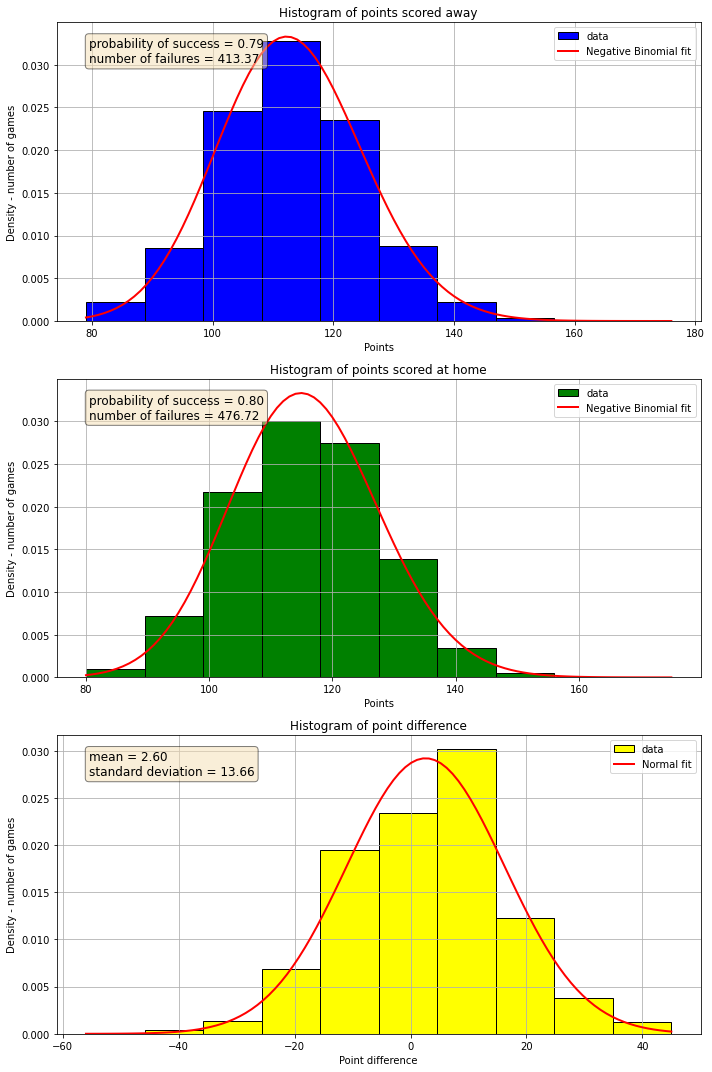

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [30]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

# 2. Evaluation of Poisson and Negative Binomial Models

The primary distinction lies in the flexibility of the Negative Binomial model, which introduces an additional parameter compared to the Poisson model. This additional parameter allows the Negative Binomial model to better accommodate the variability in the data, leading to improved predictive accuracy.

Negative Binomial provides a better fit for the data due to its ability to handle overdispersion, which is a common characteristic in sports data where the variance exceeds the mean. Negative Binomial model consistently outperforms the Poisson model in terms of predictive accuracy.

The Poisson model is described by a single parameter (λ), representing the mean number of events, while the Negative Binomial model introduces an additional parameter (r), which accounts for the overdispersion. The data required for these models include the observed counts of events, such as scores in basketball games, along with other covariates that may influence the outcome.

## Model 1 - poisson

### Prior

Prior parameters were chosen experimentally

In [31]:
model_normal_prior = CmdStanModel(stan_file='src/model/model_normal_prior.stan')
samples = 1000
sim_normal_prior=model_normal_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [32]:
mod_norm_pri = sim_normal_prior.draws_pd()
print(mod_norm_pri)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0          133.048          73.4324      28.9558   
1      0.0            0.0          136.457          83.4988      20.4017   
2      0.0            0.0          146.917          70.7096      22.2580   
3      0.0            0.0          116.197         114.1200      17.7234   
4      0.0            0.0          102.155         121.4640      18.0343   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0          132.450         120.7370      25.3618   
3996   0.0            0.0          100.048         121.4890      18.2276   
3997   0.0            0.0          121.286         106.4120      26.9260   
3998   0.0            0.0          153.723         118.5710      30.3817   
3999   0.0            0.0          119.654         103.2220      12.0758   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

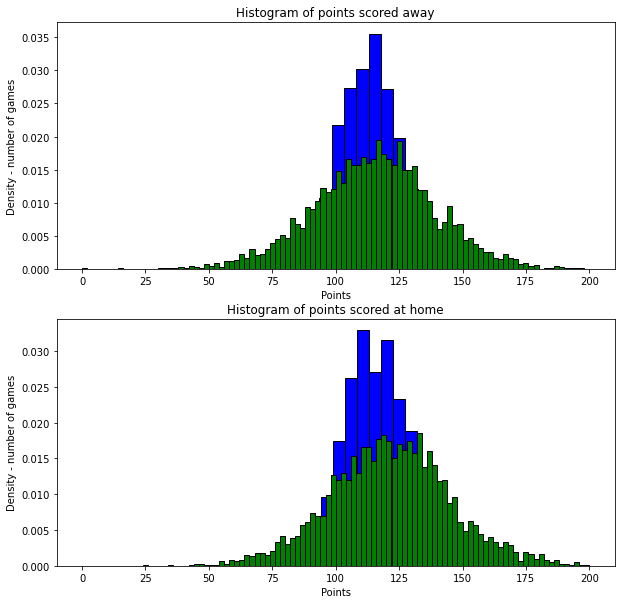

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_normal_prior.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_normal_prior.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

## MODEL 2

### Prior

Prior parameters were chosen experimentally

In [34]:
model_nbinomial_prior = CmdStanModel(stan_file='src/model/model_nbinomial_prior.stan')
samples = 1000
sim_nbin_prior=model_nbinomial_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [35]:
mod_nbin_prior = sim_nbin_prior.draws_pd()
print(mod_nbin_prior)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0            142.0            103.0     0.093663   
1      0.0            0.0            124.0            112.0     1.602980   
2      0.0            0.0            141.0            143.0    -0.484409   
3      0.0            0.0            136.0            108.0     0.807241   
4      0.0            0.0             92.0            170.0    -0.667535   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0            149.0            111.0     1.162830   
3996   0.0            0.0            139.0            161.0    -0.832367   
3997   0.0            0.0            109.0             77.0    -2.085200   
3998   0.0            0.0            154.0             81.0     0.470081   
3999   0.0            0.0            100.0             49.0     0.921381   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

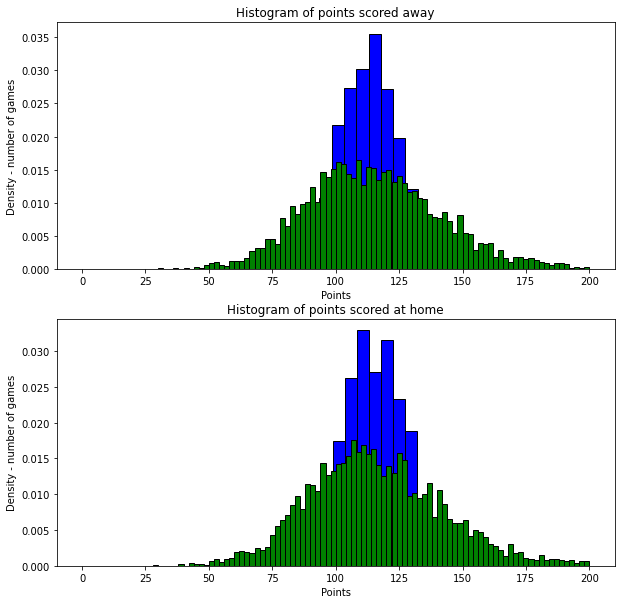

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nbin_prior.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nbin_prior.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [37]:
model_nbinomial_post = CmdStanModel(stan_file='src/model/model_nbinomial_posterior.stan')
samples = 10000
sim_nbinomial_post=model_nbinomial_post.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:31 Sampling completed                         


INFO:cmdstanpy:CmdStan done processing.


In [38]:
mod_nbin_post = sim_nbinomial_post.draws_pd()
print(mod_nbin_post)

         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -41159.5            0.0     14.3855          0.0           1.0   
1    -41159.5            0.0     14.3855          0.0           1.0   
2    -41159.5            0.0     14.3855          0.0           1.0   
3    -41159.5            0.0     14.3855          0.0           1.0   
4    -41159.5            0.0     14.3855          0.0           1.0   
...       ...            ...         ...          ...           ...   
9995 -41159.5            0.0     14.3855          0.0           1.0   
9996 -41159.5            0.0     14.3855          0.0           1.0   
9997 -41159.5            0.0     14.3855          0.0           1.0   
9998 -41159.5            0.0     14.3855          0.0           1.0   
9999 -41159.5            0.0     14.3855          0.0           1.0   

      divergent__  energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             1.0   41225.1     -1.09715     0.634745     -1.62828  ... 

Text(0, 0.5, 'Density - number of games')

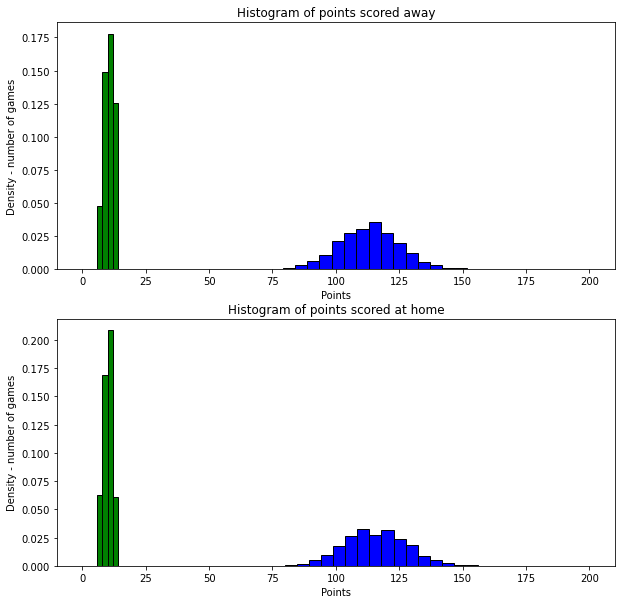

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nbinomial_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nbinomial_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

## Poisson model

### Prior

In [40]:
model_poiss_prior = CmdStanModel(stan_file='src/model/model_poisson_prior.stan')
samples = 1000
sim_poiss_prior=model_poiss_prior.sample(data=inp_data,
                     iter_sampling=samples,
                     #iter_warmup=1,
                     chains=4
                     )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [41]:
mod_poiss_prio = sim_poiss_prior.draws_pd()
print(mod_poiss_prio)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0             99.0            126.0     0.869432   
1      0.0            0.0             99.0            124.0     0.140501   
2      0.0            0.0            148.0             75.0    -1.196130   
3      0.0            0.0            113.0            160.0    -0.454171   
4      0.0            0.0            103.0            109.0     0.842469   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0             79.0            119.0    -0.255233   
3996   0.0            0.0            133.0            139.0     1.250930   
3997   0.0            0.0             95.0            107.0    -0.886596   
3998   0.0            0.0            147.0            113.0     2.367630   
3999   0.0            0.0            111.0             79.0     1.040190   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

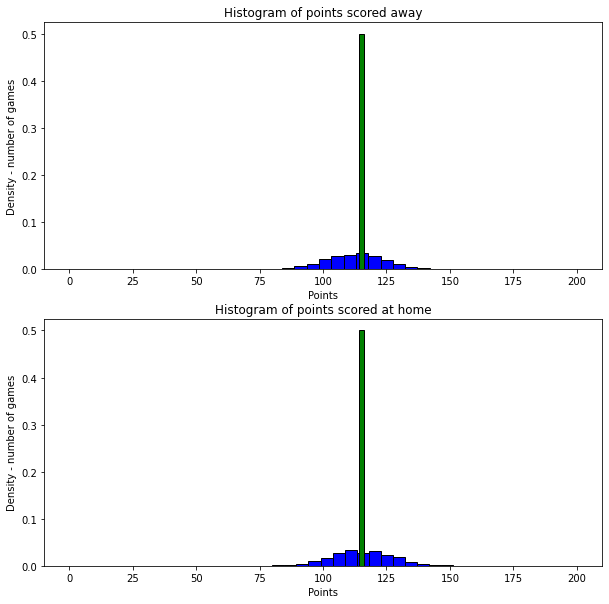

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_poiss_prior.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_poiss_prior.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

### Posterior

In [44]:
model_poiss_post = CmdStanModel(stan_file='src/model/model_poisson_posterior.stan')
samples = 1000
sim_poiss_post=model_poiss_post.sample(data=inp_data,
                     iter_sampling=samples,
                     #iter_warmup=1,
                     chains=4
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_poisson_posterior.stan to exe file /app/src/model/model_poisson_posterior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_poisson_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)







chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)
























chain 1 |█▊        | 00:22 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:23 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:29 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:36 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:43 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:50 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:56 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████▉    | 00:59 Iteration: 1001 / 2000 [ 50%]  (Sa


INFO:cmdstanpy:CmdStan done processing.


In [45]:
mod_poiss_post = sim_poiss_post.draws_pd()
print(mod_poiss_post)

           lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0     1081400.0       0.974313    0.007607          4.0          15.0   
1     1081400.0       0.916456    0.007607          4.0          15.0   
2     1081420.0       0.930062    0.007607          4.0          15.0   
3     1081420.0       0.765558    0.007607          3.0           7.0   
4     1081420.0       0.905980    0.007607          4.0          15.0   
...         ...            ...         ...          ...           ...   
3995  1081410.0       0.858219    0.027182          7.0         127.0   
3996  1081430.0       0.918455    0.027182          7.0         127.0   
3997  1081420.0       0.875495    0.027182          7.0         127.0   
3998  1081400.0       0.707577    0.027182          7.0         127.0   
3999  1081420.0       0.996819    0.027182          7.0         127.0   

      divergent__   energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             0.0 -1081350.0     0.000138     0

Text(0, 0.5, 'Density - number of games')

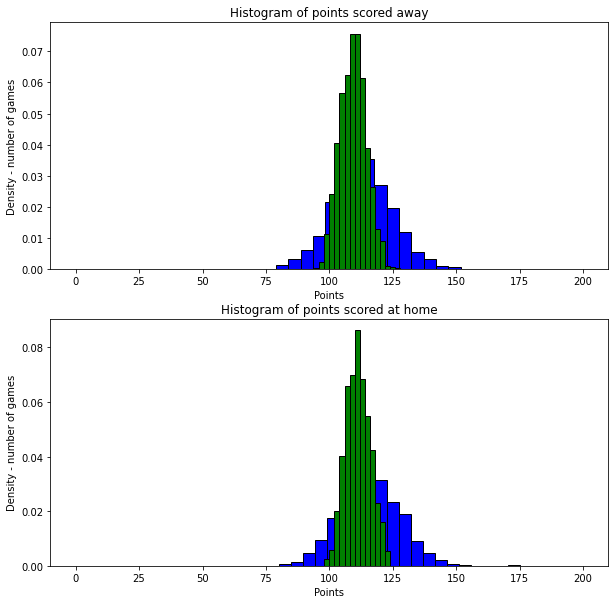

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_poiss_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_poiss_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


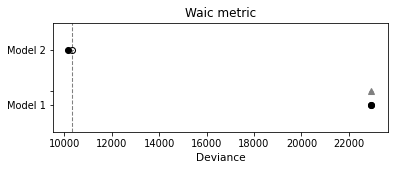

In [47]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nbinomial_post, log_likelihood={"home": "log_lik_home"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"home": "log_lik_home"})

# Comparing models
comp_dict = {'Model 1': idata_nbin, "Model 2": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


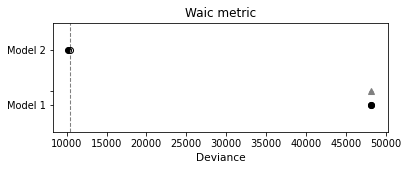

In [48]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nbinomial_post, log_likelihood={"away": "log_lik_away"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"away": "log_lik_away"})

# Comparing models
comp_dict = {'Model 1': idata_nbin, "Model 2": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()